# [MATH2504 Programming of Simulation, Analysis, and Learning Systems at The University of Queensland](https://courses.smp.uq.edu.au/MATH2504/)

## Semester 2, 2022

# Practical I: Towards Project 3 - Machine Learning

In this practical we explore basic machine learning towards project 3.

The focus is on Logistic Regression for binary classification.

In the previous practical we saw logistic regression for small (few features/variables) using the GLM.jl package. In this practical we'll implement logistic regression from first principles.

# The FashionMNIST dataset

It is similar to MNIST (used in lecture) yet using `classnames()` is more important because the labels are no longer the sequential digits.

In [1]:
using MLDatasets
train_data = FashionMNIST.traindata(Float64)

train_imgs = train_data[1]
@show typeof(train_imgs)
@show size(train_imgs)

train_labels = train_data[2]
@show typeof(train_labels);

typeof(train_imgs) = Array{Float64, 3}
size(train_imgs) = (28, 28, 60000)
typeof(train_labels) = Vector{Int64}


In [2]:
test_data = FashionMNIST.testdata(Float64)
test_imgs = test_data[1]
test_labels = test_data[2]
@show size(test_imgs);

size(test_imgs) = (28, 28, 10000)


In [3]:
class_names = FashionMNIST.classnames()

10-element Vector{String}:
 "T-Shirt"
 "Trouser"
 "Pullover"
 "Dress"
 "Coat"
 "Sandal"
 "Shirt"
 "Sneaker"
 "Bag"
 "Ankle boot"

The first 12 labels: ["Ankle boot", "T-Shirt", "T-Shirt", "Dress", "T-Shirt", "Pullover", "Sneaker", "Pullover", "Sandal", "Sandal", "T-Shirt", "Ankle boot"]


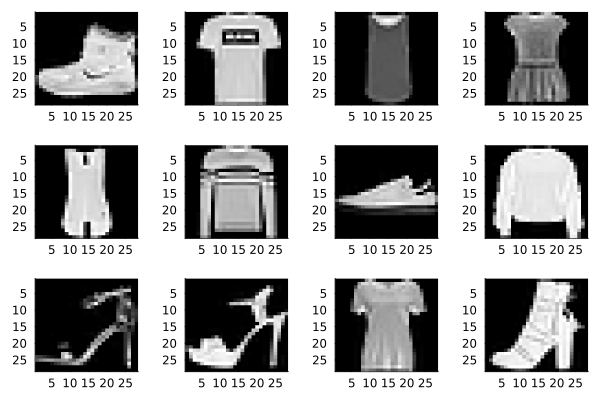

In [4]:
using Plots, Measures, LaTeXStrings
println("The first 12 labels: ", [class_names[k+1] for k in train_labels[1:12]])
plot([heatmap(train_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


It is exactly balanced:

In [5]:
using StatsBase
@show counts(train_labels)
@show counts(test_labels);

counts(train_labels) = [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
counts(test_labels) = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Whereas MNIST is only approximatly balanced:

In [6]:
@show counts(MNIST.traindata(Float64)[2])
@show counts(MNIST.testdata(Float64)[2]);

counts((MNIST.traindata(Float64))[2]) = [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
counts((MNIST.testdata(Float64))[2]) = [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


# Lets make a logistic regression classifier to classify between a "Sandal" and an "Ankle Boot"

In [7]:
sandal_index = findfirst(==("Sandal"),class_names) - 1 #the -1 is because indexing starts from 0

5

In [8]:
boot_index = findfirst(==("Ankle boot"),class_names) - 1

9

In [9]:
size(train_imgs)

(28, 28, 60000)

In [10]:
sandal_imgs = train_imgs[:,:,train_labels .== sandal_index];
size(sandal_imgs)

(28, 28, 6000)

In [11]:
boot_imgs = train_imgs[:,:,train_labels .== boot_index];
size(boot_imgs)

(28, 28, 6000)

Here are some Sandals

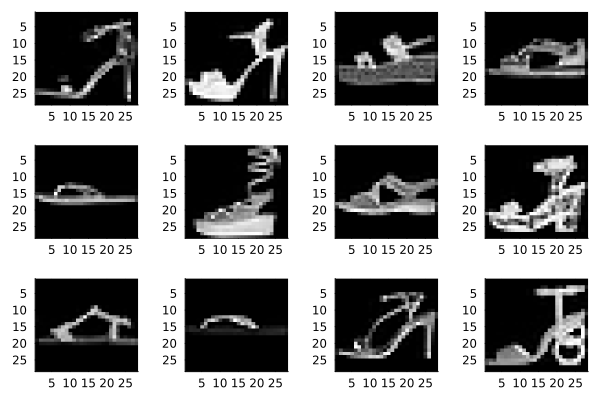

In [12]:
plot([heatmap(sandal_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


Here are some boots 

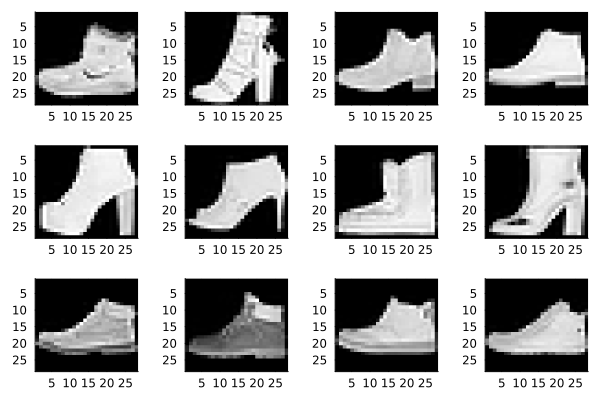

In [13]:
plot([heatmap(boot_imgs[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:12]...)


In [14]:
n_sandals_train = last(size(sandal_imgs))

6000

In [15]:
n_boots_train = last(size(boot_imgs))

6000

In [16]:
sandal_imgs_as_vectors = vcat([vec(sandal_imgs[:,:,k])' for k in 1:n_sandals_train]...)
size(sandal_imgs_as_vectors)

(6000, 784)

In [17]:
boot_imgs_as_vectors = vcat([vec(boot_imgs[:,:,k])' for k in 1:n_boots_train]...)
size(boot_imgs_as_vectors)

(6000, 784)

In [18]:
train_data_2_class = vcat(sandal_imgs_as_vectors, boot_imgs_as_vectors)
@show size(train_data_2_class)
heatmap(train_data_2_class,legend=false)

size(train_data_2_class) = (12000, 784)


The labels are just 1's for Ankle boots and 0's for Sandals:

In [19]:
train_labels_2_class = vcat(zeros(6000),ones(6000))

12000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [20]:
n_train_2_class = size(train_data_2_class)[1]

12000

In [21]:
using StatsBase, Random
Random.seed!(0)
perm = shuffle(1:n_train_2_class)
train_data_2_class = train_data_2_class[perm,:]
train_labels_2_class = train_labels_2_class[perm,:]
heatmap(train_data_2_class,legend=false)

## Logistic regression model

In [22]:
sig(x) = 1/(1+float(MathConstants.e)^-x)

sig (generic function with 1 method)

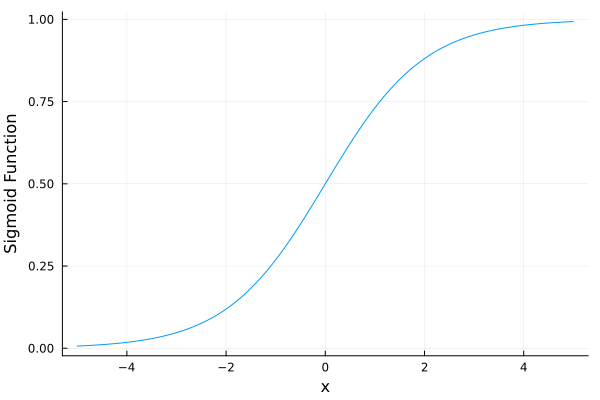

In [23]:
plot(-5:0.1:5,sig.(-5:0.1:5), xlabel = "x", ylabel = "Sigmoid Function",label=false)

The logistic regression model for predicting the probability of being an ankle boot:

In [24]:
logistic_predict(img_vec, w, b) = sig.(w'*img_vec .+ b);

The classifier returning `true` if classified as "ankle boot", otherwise `false`:

In [25]:
logistic_classifier(img_vec, w, b) = logistic_predict(img_vec, w, b) .> 0.5; #Threhsold for predicting a positive sample

We'll just use some helper functions from the `Flux.jl` package.

In [26]:
using Flux
using Flux: binarycrossentropy #Loss function
using Flux: params #Used for automatic differenation (but in Project replace auto-diff with explicit gradient)

The training loop, similar to the training loop in the lecture for the (more complicated) "softmax logistic regression (multi-class)" model:

In [27]:
using Random
Random.seed!(0)

#η is the learning rate.  \eta + [TAB]
function train_logistic(;num_epochs = 20, mini_batch_size = 100, η = 0.01)
    
    #Initilize parameters
    w = randn(28*28)
    b = randn(1)

    #As a loss function for training, We'll use the binary cross entropy 
    #which takes in a probability in [0,1]
    #and an actual label in {0,1}. The probability (of Ankle boot) 
    #in [0,1] is determined by the logistic model.
    loss(x, y) = binarycrossentropy(logistic_predict(x, w, b), y);
    
    loss_value = 0.0

    #Training loop
    for epoch_num in 1:num_epochs
        
        #Loop over mini-batches in epoch
        start_time = time_ns()
        for batch in Iterators.partition(1:n_train_2_class, mini_batch_size)
            gs = gradient(()->loss(train_data_2_class'[:,batch], train_labels_2_class[batch]'), params(w, b))
            b = b - η*gs[b]
            w = w - η*gs[w]
        end
        end_time = time_ns()

        #record/display progress
        loss_value = loss(train_data_2_class', train_labels_2_class')
        println("Epoch = $epoch_num ($(round((end_time-start_time)/1e9,digits=2)) sec) Loss = $loss_value")
        
    end
    return w, b
end

# Train model parameters
w, b = train_logistic();

Epoch = 1 (27.14 sec) Loss = 1.5538580532184563
Epoch = 2 (1.79 sec) Loss = 1.2309614521691343
Epoch = 3 (1.73 sec) Loss = 1.061140302744214
Epoch = 4 (1.64 sec) Loss = 0.9498141593420252
Epoch = 5 (1.58 sec) Loss = 0.867375842709328
Epoch = 6 (1.65 sec) Loss = 0.8025890025434098
Epoch = 7 (1.79 sec) Loss = 0.7499976505738688
Epoch = 8 (1.68 sec) Loss = 0.7063618379008137
Epoch = 9 (1.77 sec) Loss = 0.6695085637363417
Epoch = 10 (1.6 sec) Loss = 0.6378929778402276
Epoch = 11 (1.59 sec) Loss = 0.6103926821308742
Epoch = 12 (1.76 sec) Loss = 0.5861839926399195
Epoch = 13 (1.64 sec) Loss = 0.5646544187410456
Epoch = 14 (1.61 sec) Loss = 0.5453407462753862
Epoch = 15 (1.62 sec) Loss = 0.5278858812260728
Epoch = 16 (1.63 sec) Loss = 0.5120090600522287
Epoch = 17 (1.62 sec) Loss = 0.49748554140096635
Epoch = 18 (1.68 sec) Loss = 0.4841326706860174
Epoch = 19 (1.66 sec) Loss = 0.47180008880158947
Epoch = 20 (1.64 sec) Loss = 0.46036267350139737


### First just play around with a few examples.

In [28]:
first_sandal_vector = sandal_imgs_as_vectors[1,:];
first_boot_vector = boot_imgs_as_vectors[1,:];

In [29]:
logistic_predict(first_sandal_vector,w,b)

1-element Vector{Float64}:
 0.02549535777034436

In [30]:
logistic_predict(first_boot_vector,w,b)

1-element Vector{Float64}:
 0.937376473658355

In [31]:
logistic_classifier(first_sandal_vector,w,b)

1-element BitVector:
 0

In [32]:
logistic_classifier(first_boot_vector,w,b)

1-element BitVector:
 1

### Now let's see it on the test set

In [33]:
size(test_imgs)

(28, 28, 10000)

In [34]:
test_sandal_images = test_imgs[:,:,test_labels .== sandal_index]
size(test_sandal_images)

(28, 28, 1000)

In [35]:
test_boot_images = test_imgs[:,:,test_labels .== boot_index]
size(test_boot_images)

(28, 28, 1000)

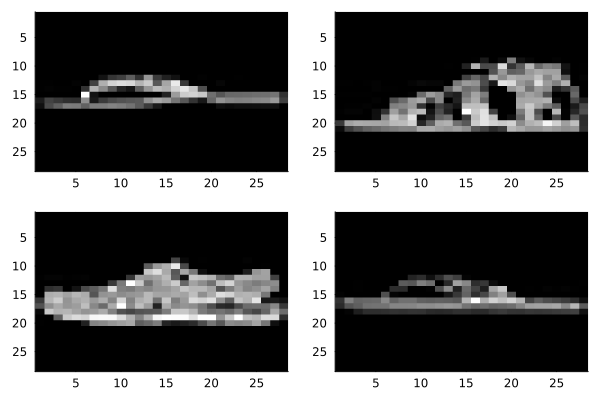

In [36]:
plot([heatmap(test_sandal_images[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:4]...)

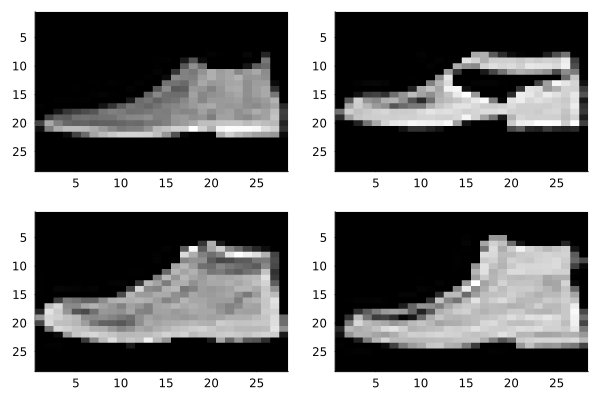

In [37]:
plot([heatmap(test_boot_images[:,:,k]',
            yflip=true,legend=false,c=cgrad([:black, :white])) for k in 1:4]...)

In [38]:
test_sandal_imgs_as_vectors = vcat([vec(test_sandal_images[:,:,k])' for k in 1:1000]...)
size(test_sandal_imgs_as_vectors)

(1000, 784)

In [39]:
test_boot_imgs_as_vectors = vcat([vec(test_boot_images[:,:,k])' for k in 1:1000]...)
size(test_boot_imgs_as_vectors)

(1000, 784)

In [40]:
logistic_classifier(test_sandal_imgs_as_vectors',w,b)

1×1000 BitMatrix:
 0  1  0  0  1  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0

This is the "false positive rate" (positive to think it is a boot... but actually it is "false" because it is a Sandal):

In [41]:
mean(logistic_classifier(test_sandal_imgs_as_vectors',w,b))

0.205

In [42]:
logistic_classifier(test_boot_imgs_as_vectors',w,b)

1×1000 BitMatrix:
 1  0  1  1  1  1  1  1  0  1  0  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1

This is the 1-(false negative rate) "boots correctly classified as boots.

In [43]:
mean(logistic_classifier(test_boot_imgs_as_vectors',w,b))

0.906

The accuracy:

In [44]:
mean([logistic_classifier(test_sandal_imgs_as_vectors',w,b) .== zeros(1000)' logistic_classifier(test_boot_imgs_as_vectors',w,b) .== ones(1000)'])

0.8505